# Housing Area Regression with PyTorch

This notebook demonstrates a neural network regression model for predicting housing area using PyTorch. It includes data loading, preprocessing, model training, evaluation, and benchmarking against a linear regression baseline.

In [13]:
# Install required packages
!pip install -q torch scikit-learn matplotlib xgboost

## 1. Imports and Setup

In [2]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error
)
from sklearn.linear_model import LinearRegression

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

## 2. Data Loading and Preprocessing

In [3]:
# Load dataset
df = pd.read_csv("data/housing_price_gold.csv")
label = "area"
drop_columns = []
features = [col for col in df.columns if col != label and col not in drop_columns]

# Create tensors
X = torch.tensor(df[features].values, dtype=torch.float32)
y = torch.tensor(df[label].values, dtype=torch.float32)

# Create tensor dataset
ds = TensorDataset(X, y)

# Split data
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
ds_train, ds_test = random_split(ds, [train_size, test_size])

train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)

# Prepare full train/test tensors for evaluation
X_train = ds_train.dataset.tensors[0][ds_train.indices]
y_train = ds_train.dataset.tensors[1][ds_train.indices]
X_test = ds_test.dataset.tensors[0][ds_test.indices]
y_test = ds_test.dataset.tensors[1][ds_test.indices]

## 3. Neural Network Regression Model

In [4]:
class Regression(nn.Module):
    def __init__(
        self, input_size: int, hidden1_size: int, hidden2_size: int, output_size: int
    ):
        super(Regression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 4. Training the Model

In [5]:
# Model, optimizer, and loss
model = Regression(
    input_size=len(features), hidden1_size=96, hidden2_size=48, output_size=1
)
epochs = 300
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Logs
MAE_train_log, MAPE_train_log = [], []
MAE_test_log, MAPE_test_log = [], []

for epoch in range(1, epochs + 1):
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch).squeeze(-1)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        # Test
        y_pred_test = model(X_test).squeeze(-1)
        MAE_test = mean_absolute_error(y_test, y_pred_test)
        MAPE_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100
        MAE_test_log.append(MAE_test)
        MAPE_test_log.append(MAPE_test)
        # Train
        y_pred_train = model(X_train).squeeze(-1)
        MAE_train = mean_absolute_error(y_train, y_pred_train)
        MAPE_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100
        MAE_train_log.append(MAE_train)
        MAPE_train_log.append(MAPE_train)
    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:3d}/{epochs} | Train MAE: {MAE_train:.2f} | Test MAE: {MAE_test:.2f}"
        )

Epoch   1/300 | Train MAE: 5109.79 | Test MAE: 5311.04
Epoch  10/300 | Train MAE: 5050.22 | Test MAE: 5252.68
Epoch  20/300 | Train MAE: 4486.69 | Test MAE: 4702.63
Epoch  30/300 | Train MAE: 3069.49 | Test MAE: 3306.65
Epoch  40/300 | Train MAE: 1824.95 | Test MAE: 2131.83
Epoch  50/300 | Train MAE: 1582.82 | Test MAE: 1955.97
Epoch  60/300 | Train MAE: 1529.37 | Test MAE: 1895.28
Epoch  70/300 | Train MAE: 1488.37 | Test MAE: 1832.21
Epoch  80/300 | Train MAE: 1453.64 | Test MAE: 1773.95
Epoch  90/300 | Train MAE: 1426.83 | Test MAE: 1725.58
Epoch 100/300 | Train MAE: 1403.75 | Test MAE: 1686.20
Epoch 110/300 | Train MAE: 1389.29 | Test MAE: 1654.74
Epoch 120/300 | Train MAE: 1373.86 | Test MAE: 1624.63
Epoch 130/300 | Train MAE: 1359.54 | Test MAE: 1597.33
Epoch 140/300 | Train MAE: 1346.98 | Test MAE: 1573.56
Epoch 150/300 | Train MAE: 1341.16 | Test MAE: 1559.52
Epoch 160/300 | Train MAE: 1329.16 | Test MAE: 1539.10
Epoch 170/300 | Train MAE: 1323.51 | Test MAE: 1525.64
Epoch 180/

## 5. Training Curves

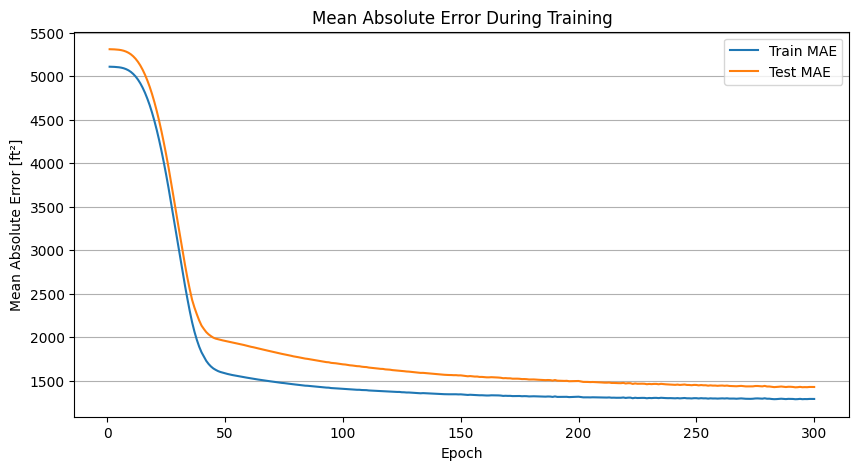

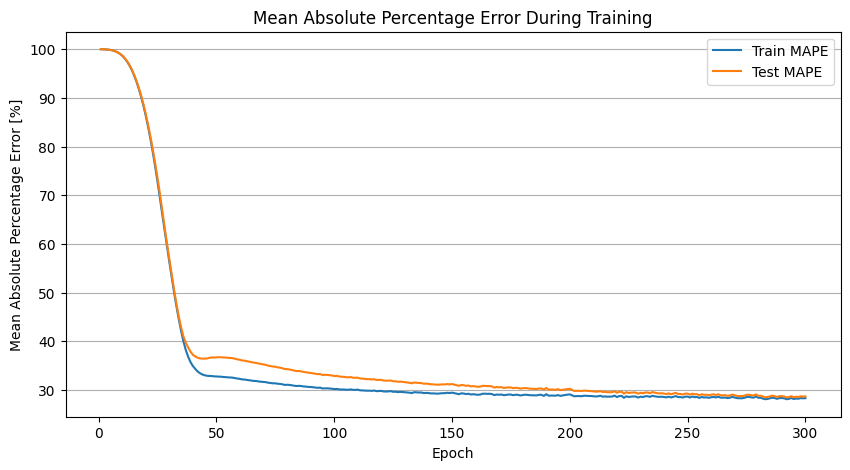

In [6]:
epochs_range = list(range(1, epochs + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, MAE_train_log, label="Train MAE")
plt.plot(epochs_range, MAE_test_log, label="Test MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error [ft²]")
plt.title("Mean Absolute Error During Training")
plt.grid(True, axis="y")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, MAPE_train_log, label="Train MAPE")
plt.plot(epochs_range, MAPE_test_log, label="Test MAPE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Percentage Error [%]")
plt.title("Mean Absolute Percentage Error During Training")
plt.grid(True, axis="y")
plt.legend()
plt.show()

## 6. Final Model Evaluation

In [9]:
with torch.no_grad():
    pred = model(X_test).squeeze(-1)
    ft_sq_to_m_sq = 0.092903
    MAE = mean_absolute_error(y_test, pred)
    MSE = mean_squared_error(y_test, pred)
    MAPE = mean_absolute_percentage_error(y_test, pred) * 100
    R2 = r2_score(y_test, pred)
    RMSE  = root_mean_squared_error(y_test, pred)
    print(f"Neural Network Regression Results:")
    print(f"MAE: {MAE:.2f} ft² ({MAE*ft_sq_to_m_sq:.2f} m²)")
    print(f"MSE: {MSE:.2f} ft² ({MSE*ft_sq_to_m_sq:.2f} m²)")
    print(f"MAPE: {MAPE:.2f}%")
    print(f"R²: {R2:.3f}")
    print(f"RMSE: {RMSE:.2f} ft² ({RMSE*ft_sq_to_m_sq:.2f} m²)")

Neural Network Regression Results:
MAE: 1425.78 ft² (132.46 m²)
MSE: 4288105.44 ft² (398377.86 m²)
MAPE: 28.69%
R²: 0.174
RMSE: 2070.77 ft² (192.38 m²)


## 7. Benchmark: Linear Regression

In [10]:
benchmark_model = LinearRegression()
benchmark_model.fit(X_train, y_train)
pred_bench = benchmark_model.predict(X_test)
MAE_bench = mean_absolute_error(y_test, pred_bench)
MSE_bench = mean_squared_error(y_test, pred_bench)
MAPE_bench = mean_absolute_percentage_error(y_test, pred_bench) * 100
R2_bench = r2_score(y_test, pred_bench)
RMSE  = root_mean_squared_error(y_test, pred)
print(f"Linear Regression Benchmark:")
print(f"MAE: {MAE_bench:.2f} ft² ({MAE_bench*ft_sq_to_m_sq:.2f} m²)")
print(f"MSE: {MSE_bench:.2f}")
print(f"MAPE: {MAPE_bench:.2f}%")
print(f"R²: {R2_bench:.3f}")
print(f"RMSE: {RMSE:.2f} ft² ({RMSE*ft_sq_to_m_sq:.2f} m²)")

Linear Regression Benchmark:
MAE: 1374.70 ft² (127.71 m²)
MSE: 3930125.00
MAPE: 26.92%
R²: 0.243
RMSE: 2070.77 ft² (192.38 m²)


### Comment
High Mean Percentage Error value (around 30%) points out poor model performence. The resaons behind it can be:
* Small dataset - 545 records for multiparameter reggression can be unsufficient
* Bad data quality - the source dataset was designed for **price prediction** and not **area prediction**. Data does not provide enough features to make a precise prediction for a size of a house.

## 8. Testing other regression models

In [ ]:
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# with default parmeters
models = {
    "SVR": SVR(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor()
}

for model in models:
    print(f"\nTraining {model}...")
    models[model].fit(X_train, y_train)
    pred = models[model].predict(X_test)
    MAE = mean_absolute_error(y_test, pred)
    MSE = mean_squared_error(y_test, pred)
    MAPE = mean_absolute_percentage_error(y_test, pred) * 100
    R2 = r2_score(y_test, pred)
    RMSE  = root_mean_squared_error(y_test, pred)
    print(f"{model} Results:")
    print(f"MAE: {MAE:.2f} ft² ({MAE*ft_sq_to_m_sq:.2f} m²)")
    print(f"MSE: {MSE:.2f}")
    print(f"MAPE: {MAPE:.2f}%")
    print(f"R²: {R2:.3f}")
    print(f"RMSE: {RMSE:.2f} ft² ({RMSE*ft_sq_to_m_sq:.2f} m²)")


Training SVR...
SVR Results:
MAE: 1772.76 ft² (164.69 m²)
MSE: 5792191.14
MAPE: 33.40%
R²: -0.115
RMSE: 2406.70 ft² (223.59 m²)

Training KNeighborsRegressor...
KNeighborsRegressor Results:
MAE: 1493.12 ft² (138.71 m²)
MSE: 4912865.00
MAPE: 28.79%
R²: 0.054
RMSE: 2216.50 ft² (205.92 m²)

Training RandomForestRegressor...
RandomForestRegressor Results:
MAE: 1367.31 ft² (127.03 m²)
MSE: 3746377.06
MAPE: 26.63%
R²: 0.279
RMSE: 1935.56 ft² (179.82 m²)

Training XGBRegressor...
XGBRegressor Results:
MAE: 1530.10 ft² (142.15 m²)
MSE: 4779909.50
MAPE: 28.77%
R²: 0.080
RMSE: 2186.30 ft² (203.11 m²)


## 9. Optimization by random search

In [27]:
import numpy as np

np.random.seed(42)

tuned_models = {
    "SVR": None,
    "KNeighborsRegressor": None,
    "RandomForestRegressor": None,
    "XGBRegressor": None
}

parameters = {
    SVR: {
        "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
        "C": np.linspace(0.1, 2, num=50),
        "epsilon": np.linspace(0, 1, num=50)
    },
    KNeighborsRegressor: {
        "n_neighbors": np.arange(1, 20),
        "weights": ['uniform', 'distance'],
        "metric": ['euclidean', 'manhattan', 'minkowski'],
    },
    RandomForestRegressor: {
        "n_estimators": np.arange(10, 200, 2),
        "max_depth": np.arange(1, 50),
        "min_samples_split": np.arange(2, 10),
        "max_features": ['sqrt', 'log2'],
    },
    XGBRegressor: {
        "learning_rate": np.linspace(0.001, 0.1, 100),
        "n_estimators": np.arange(10, 200, 2),
        "max_depth": np.arange(1, 50),
    }
}

for model_type, parameter_ranges in parameters.items():
    generations = 1000
    print(f"\nTuning {model_type}...")
    best_MAPE = np.inf
    for generation in range(1, generations + 1):
        parameters = {n: np.random.choice(v) for n, v in parameter_ranges.items()}
        model = model_type(**parameters)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        MAPE = mean_absolute_percentage_error(y_test, pred) * 100
        if MAPE < best_MAPE:
            best_MAPE = MAPE
            tuned_models[model_type] = model
            print(f"Generation {generation}: {model_type} MAPE: {MAPE:.2f}% | Parameters: {parameters}")
    



Tuning <class 'sklearn.svm._classes.SVR'>...
Generation 1: <class 'sklearn.svm._classes.SVR'> MAPE: 33.38% | Parameters: {'kernel': np.str_('rbf'), 'C': np.float64(1.1857142857142857), 'epsilon': np.float64(0.2857142857142857)}
Generation 8: <class 'sklearn.svm._classes.SVR'> MAPE: 31.57% | Parameters: {'kernel': np.str_('poly'), 'C': np.float64(0.9142857142857143), 'epsilon': np.float64(0.8775510204081632)}
Generation 11: <class 'sklearn.svm._classes.SVR'> MAPE: 30.98% | Parameters: {'kernel': np.str_('poly'), 'C': np.float64(1.8836734693877553), 'epsilon': np.float64(0.8775510204081632)}
Generation 15: <class 'sklearn.svm._classes.SVR'> MAPE: 30.94% | Parameters: {'kernel': np.str_('poly'), 'C': np.float64(2.0), 'epsilon': np.float64(0.16326530612244897)}
Generation 539: <class 'sklearn.svm._classes.SVR'> MAPE: 30.93% | Parameters: {'kernel': np.str_('poly'), 'C': np.float64(2.0), 'epsilon': np.float64(0.12244897959183673)}
Generation 929: <class 'sklearn.svm._classes.SVR'> MAPE: 30

In [30]:
print("Best Tuned Models:")
for model_name, model in tuned_models.items():
    if model is not None:
        pred = model.predict(X_test)
        MAE = mean_absolute_error(y_test, pred)
        MSE = mean_squared_error(y_test, pred)
        MAPE = mean_absolute_percentage_error(y_test, pred) * 100
        R2 = r2_score(y_test, pred)
        RMSE  = root_mean_squared_error(y_test, pred)
        print(f"\n{model_name} Results:")
        print(f"MAE: {MAE:.2f} ft² ({MAE*ft_sq_to_m_sq:.2f} m²)")
        print(f"MSE: {MSE:.2f}")
        print(f"MAPE: {MAPE:.2f}%")
        print(f"R²: {R2:.3f}")
        print(f"RMSE: {RMSE:.2f} ft² ({RMSE*ft_sq_to_m_sq:.2f} m²)")

Best Tuned Models:

<class 'sklearn.svm._classes.SVR'> Results:
MAE: 1644.52 ft² (152.78 m²)
MSE: 5555304.14
MAPE: 30.93%
R²: -0.070
RMSE: 2356.97 ft² (218.97 m²)

<class 'sklearn.neighbors._regression.KNeighborsRegressor'> Results:
MAE: 1347.98 ft² (125.23 m²)
MSE: 4043993.12
MAPE: 25.53%
R²: 0.221
RMSE: 2010.97 ft² (186.82 m²)

<class 'sklearn.ensemble._forest.RandomForestRegressor'> Results:
MAE: 1274.13 ft² (118.37 m²)
MSE: 3776522.47
MAPE: 24.08%
R²: 0.273
RMSE: 1943.33 ft² (180.54 m²)

<class 'xgboost.sklearn.XGBRegressor'> Results:
MAE: 1308.36 ft² (121.55 m²)
MSE: 3666761.00
MAPE: 24.88%
R²: 0.294
RMSE: 1914.88 ft² (177.90 m²)


**The winner is RanomForestRegressor!**